In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability.python.distributions as tfd

In [4]:
from networks import *

Three archetypes are defined on a two dimensional space.

In [5]:
archetypes_init = np.array([[1,0],
                  [2,2],
                  [0,1]])

In [6]:
def generate_data (archs, n_points, noise=0.1):
    
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    Y0=np.linalg.norm(data-archs[0],axis=1)
    Y1=np.linalg.norm(data-archs[1],axis=1)
    Y2=np.linalg.norm(data-archs[2],axis=1)
    Y0=Y0/np.max(Y0)
    Y1=Y1/np.max(Y1)
    Y2=Y2/np.max(Y2)
    Y=np.concatenate((np.expand_dims(Y0,axis=1),np.expand_dims(Y1,axis=1),np.expand_dims(Y2,axis=1)),axis=1)
    
    return data, Y

Data is generated as a linear combination of the archetypes. Constrains on the weights are added so as to ensure that the generated data set is a convex mixture of the archetypes. Noise is then added, hence the resulting points can be defined outside the convex hull. Each data point has associated a side information vector  $\vec{Y}=(Y_0,Y_1,Y_2)$, where each component is the distance from one of the archetypes. Side information can be generalised to more complex functions. In the figure below we can see the three archetypes in blue, and the data set in different shades of red. Colors are obtained from the side information, that is used as entry for a RGB  color model.

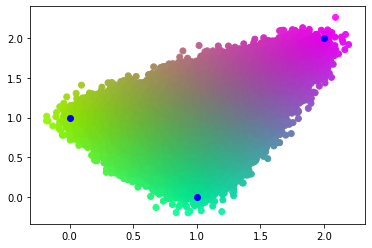

In [7]:
x_train, y_train = generate_data (archetypes_init,100000,noise=0.1)
x_test, y_test = generate_data (archetypes_init,1000,noise=0.1)

data0,data1 = x_train.T
plt.scatter(data0, data1, color=y_train)
data0,data1 = archetypes_init.T
plt.scatter(data0, data1, color='blue')


We use variational autoencoders to map the data set into a latent space. The neural network is constructed to force data in latent space to be defined within an arbitrary convex hull. We use a triangular convex hull as shown below. 

We construct a variational autoencoder that generates a mean $\mu$, and a standard deviation $\sigma$ for each data point. The point is then mapped into the latent space with a stochastic extraction from a Gaussian $\mathcal{N}(\mu,\,\sigma^{2})$, where $\mu$'s are by construction within a hull $z_{fixed}$. 

In [8]:
original_dim = x_train.shape [1]
sideinfo_dim = y_train.shape [1]

x_train = np.array(np.reshape(x_train, [-1, original_dim]), dtype='float32')
x_test = np.array(np.reshape(x_test, [-1, original_dim]), dtype='float32')
y_train = np.array(np.reshape(y_train, [-1, sideinfo_dim]), dtype='float32')
y_test = np.array(np.reshape(y_test, [-1, sideinfo_dim]), dtype='float32')


# network parameters
intermediate_dim = 4
batch_size = 1024 
latent_dim = 2
simplex_vrtxs = latent_dim + 1

vae = VAE(original_dim, intermediate_dim, latent_dim, sideinfo_dim)
vae.add_loss()
vae.network.compile(optimizer='adam')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 4)            12          encoder_input_x[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4)            20          dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            15          dense_1[0][0]                    
____________________________________________________________________________________________

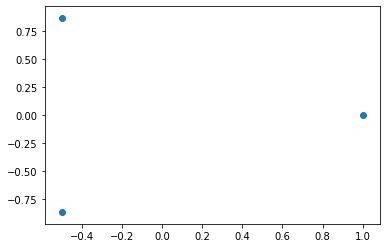

In [9]:
zfixed = vae.get_zfixed()
data0,data1 = zfixed.T
plt.scatter(data0, data1)

In [10]:
epochs = 1000

vae.network.fit([x_train,y_train],  
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,y_test],None))

Train on 100000 samples, validate on 1000 samples
Epoch 1/1000
100000/100000 [==============================] - 1s 9us/sample - loss: 2.4769 - val_loss: 2.1329
Epoch 2/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 1.8655 - val_loss: 1.7246
Epoch 3/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 1.5915 - val_loss: 1.5212
Epoch 4/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 1.4092 - val_loss: 1.3051
Epoch 5/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 1.1681 - val_loss: 1.0408
Epoch 6/1000
100000/100000 [==============================] - 0s 3us/sample - loss: 0.9117 - val_loss: 0.8021
Epoch 7/1000
100000/100000 [==============================] - 0s 3us/sample - loss: 0.6930 - val_loss: 0.6197
Epoch 8/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.5506 - val_loss: 0.5215
Epoch 9/1000
100000/100000 [==============================] - 0s 2us/s

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0734 - val_loss: 0.0785
Epoch 75/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0718 - val_loss: 0.0770
Epoch 76/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0698 - val_loss: 0.0762
Epoch 77/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0687 - val_loss: 0.0743
Epoch 78/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0696 - val_loss: 0.0724
Epoch 79/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0683 - val_loss: 0.0727
Epoch 80/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0659 - val_loss: 0.0725
Epoch 81/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0658 - val_loss: 0.0719
Epoch 82/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0660 - val_loss: 0.0719
Epoch 83/1000
1

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0588 - val_loss: 0.0644
Epoch 148/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0596 - val_loss: 0.0631
Epoch 149/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0583 - val_loss: 0.0629
Epoch 150/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0601 - val_loss: 0.0634
Epoch 151/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0633 - val_loss: 0.0630
Epoch 152/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0584 - val_loss: 0.0628
Epoch 153/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0628 - val_loss: 0.0626
Epoch 154/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0603 - val_loss: 0.0634
Epoch 155/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0601 - val_loss: 0.0637
Epoch 1

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0582 - val_loss: 0.0612
Epoch 221/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0573 - val_loss: 0.0611
Epoch 222/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0620 - val_loss: 0.0623
Epoch 223/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0570 - val_loss: 0.0612
Epoch 224/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0592 - val_loss: 0.0619
Epoch 225/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0603 - val_loss: 0.0620
Epoch 226/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0573 - val_loss: 0.0623
Epoch 227/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0592 - val_loss: 0.0618
Epoch 228/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0574 - val_loss: 0.0616
Epoch 2

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0596 - val_loss: 0.0677
Epoch 294/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0603 - val_loss: 0.0614
Epoch 295/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0570 - val_loss: 0.0611
Epoch 296/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0573 - val_loss: 0.0607
Epoch 297/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0572 - val_loss: 0.0613
Epoch 298/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0661 - val_loss: 0.0617
Epoch 299/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0577 - val_loss: 0.0627
Epoch 300/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0578 - val_loss: 0.0609
Epoch 301/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0587 - val_loss: 0.0639
Epoch 3

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0563 - val_loss: 0.0612
Epoch 367/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0562 - val_loss: 0.0614
Epoch 368/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0582 - val_loss: 0.0606
Epoch 369/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0569 - val_loss: 0.0601
Epoch 370/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0564 - val_loss: 0.0606
Epoch 371/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0565 - val_loss: 0.0603
Epoch 372/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0592 - val_loss: 0.0666
Epoch 373/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0578 - val_loss: 0.0608
Epoch 374/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0576 - val_loss: 0.0606
Epoch 3

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0569 - val_loss: 0.0604
Epoch 440/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0563 - val_loss: 0.0608
Epoch 441/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0572 - val_loss: 0.0597
Epoch 442/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0560 - val_loss: 0.0598
Epoch 443/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0560 - val_loss: 0.0599
Epoch 444/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0564 - val_loss: 0.0598
Epoch 445/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0555 - val_loss: 0.0597
Epoch 446/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0558 - val_loss: 0.0607
Epoch 447/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0592 - val_loss: 0.0613
Epoch 4

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0563 - val_loss: 0.0594
Epoch 513/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0589 - val_loss: 0.0644
Epoch 514/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0571 - val_loss: 0.0600
Epoch 515/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0571 - val_loss: 0.0598
Epoch 516/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0562 - val_loss: 0.0597
Epoch 517/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0557 - val_loss: 0.0595
Epoch 518/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0557 - val_loss: 0.0597
Epoch 519/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0566 - val_loss: 0.0615
Epoch 520/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0573 - val_loss: 0.0594
Epoch 5

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0568 - val_loss: 0.0612
Epoch 586/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0565 - val_loss: 0.0598
Epoch 587/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0615 - val_loss: 0.0606
Epoch 588/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0570 - val_loss: 0.0599
Epoch 589/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0565 - val_loss: 0.0598
Epoch 590/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0557 - val_loss: 0.0599
Epoch 591/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0558 - val_loss: 0.0595
Epoch 592/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0572 - val_loss: 0.0614
Epoch 593/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0555 - val_loss: 0.0604
Epoch 5

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0558 - val_loss: 0.0600
Epoch 659/1000
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0559 - val_loss: 0.0600
Epoch 660/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0553 - val_loss: 0.0591
Epoch 661/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0568 - val_loss: 0.0594
Epoch 662/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0563 - val_loss: 0.0593
Epoch 663/1000
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0571 - val_loss: 0.0611
Epoch 664/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0558 - val_loss: 0.0600
Epoch 665/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0558 - val_loss: 0.0594
Epoch 666/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0576 - val_loss: 0.0601
Epoch 6

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0556 - val_loss: 0.0597
Epoch 732/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0594 - val_loss: 0.0610
Epoch 733/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0557 - val_loss: 0.0603
Epoch 734/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0565 - val_loss: 0.0601
Epoch 735/1000
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0564 - val_loss: 0.0598
Epoch 736/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0563 - val_loss: 0.0609
Epoch 737/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0554 - val_loss: 0.0597
Epoch 738/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0577 - val_loss: 0.0604
Epoch 739/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0558 - val_loss: 0.0606
Epoch 7

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0569 - val_loss: 0.0596
Epoch 805/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0558 - val_loss: 0.0592
Epoch 806/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0556 - val_loss: 0.0597
Epoch 807/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0554 - val_loss: 0.0590
Epoch 808/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0575 - val_loss: 0.0600
Epoch 809/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0561 - val_loss: 0.0598
Epoch 810/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0558 - val_loss: 0.0594
Epoch 811/1000
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0566 - val_loss: 0.0595
Epoch 812/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0555 - val_loss: 0.0592
Epoch 8

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0561 - val_loss: 0.0593
Epoch 878/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0561 - val_loss: 0.0592
Epoch 879/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0562 - val_loss: 0.0592
Epoch 880/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0555 - val_loss: 0.0592
Epoch 881/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0554 - val_loss: 0.0587
Epoch 882/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0599 - val_loss: 0.0594
Epoch 883/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0596 - val_loss: 0.0590
Epoch 884/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0551 - val_loss: 0.0588
Epoch 885/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0603 - val_loss: 0.0589
Epoch 8

100000/100000 [==============================] - 0s 2us/sample - loss: 0.0559 - val_loss: 0.0600
Epoch 951/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0549 - val_loss: 0.0586
Epoch 952/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0550 - val_loss: 0.0585
Epoch 953/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0547 - val_loss: 0.0589
Epoch 954/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0566 - val_loss: 0.0614
Epoch 955/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0564 - val_loss: 0.0593
Epoch 956/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0552 - val_loss: 0.0588
Epoch 957/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0551 - val_loss: 0.0589
Epoch 958/1000
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0556 - val_loss: 0.0586
Epoch 9

In [11]:
archetypes_pred = vae.decoder.predict([vae.get_zfixed(),np.zeros([3,3])])[0]

In [12]:
t,mu,sigma, B_t, y = vae.encoder.predict([x_train,np.zeros(np.shape(y_train))])

$\mu$'s are generated within an arbitrary triangular hull. Below we see the $\mu$'s in latent space in blue, and the vertexes of the arbitrarily chosen hull in orange.

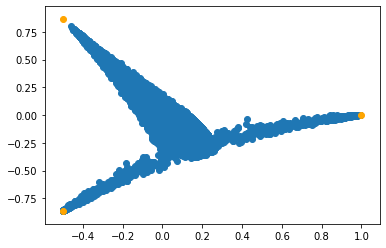

In [13]:
dataX,dataY = mu.T
plt.scatter(dataX,dataY)
zfixed = vae.get_zfixed ()
data0,data1 = zfixed.T
plt.scatter(data0, data1,color='orange')

Using the data points initially generated we are able to reconstruct the initial points that have been taken as archetypes. Below, we see in blue the archetypes initailly defined, and in orange the predicted ones.

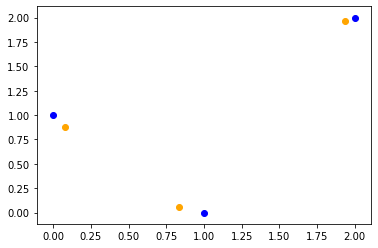

In [14]:
dataX,dataY = archetypes_init.T
plt.scatter(dataX,dataY,color='blue')

dataX,dataY = np.array(archetypes_pred).T
plt.scatter(dataX,dataY,color='orange')


We can feed the trained network with some test data and see that is able to reconstruct the data and side information after mapping into latent space.

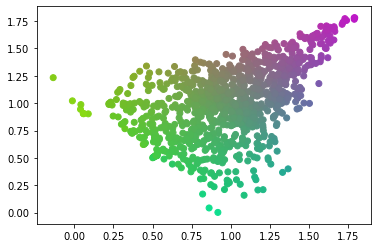

In [15]:
t, y_pred = vae.network.predict([x_test,np.zeros(np.shape(y_test))])
dataX,dataY = t.T

if (np.min(y_pred)<0):
    y_pred += np.abs(np.min(y_pred))
if (np.min(y_pred)>1):
    y_pred /= np.abs(np.max(y_pred))

plt.scatter(dataX,dataY,color=y_pred)

Below we can see the original test data. If we compare the original data with the results of the variational encoder above, we can see that the encoder has the effect of a regularizer, i.e. the resulting effect is that noise is removed and data lie within the convex hull.

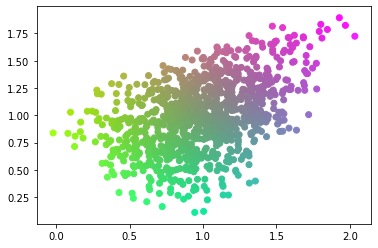

In [16]:
dataX,dataY = x_test.T
plt.scatter(dataX,dataY,color=y_test)